Author: Dylan Nikol

In [1]:
import pandas as pd
import numpy as np
import copy

# Load all data from CRSP for all stocks on AMEX, NYSE, NASDAQ
raw_data = pd.read_csv('d4509de939589f29.csv')

# Exclude AMEX from analysis
sp_data = copy.deepcopy(raw_data[raw_data.EXCHCD != 2])
dow_data =copy.deepcopy(raw_data[raw_data.EXCHCD != 2])

# S&P500 Replication

In [2]:
# Adjust shares and stock prices, format date
sp_data['PRC_ADJ'] = sp_data['PRC'] / sp_data['CFACPR']
sp_data['SHROUT_ADJ'] = (sp_data['SHROUT'] * sp_data['CFACSHR']) * 1000
sp_data['MKT_CAP'] = (sp_data['SHROUT_ADJ'] * sp_data['PRC_ADJ']).replace([np.inf, -np.inf], np.nan)
sp_data = sp_data.dropna().reset_index(drop=True)
sp_data['date'] = pd.to_datetime(sp_data['date'], format='%Y%m%d').dt.to_period('M')
dates = sp_data['date'].unique()
sp_data = sp_data.drop(["CFACPR", "CFACSHR", "PRC", "SHROUT"], axis=1)

In [3]:
def rebalance_sp(df):
    df['WEIGHT'] = df['MKT_CAP']/df['MKT_CAP'].sum()
    return df
    
def reconstitute_sp(df):
    df = df.sort_values(by='MKT_CAP', ascending=False)[0:505].reset_index(drop=True)
    df = rebalance_sp(df)
    return df

In [4]:
col = ['date','PERMNO','TICKER','MKT_CAP', 'WEIGHT']
s_p = pd.DataFrame(np.zeros((0,len(col))), columns=col)
s_p500 = pd.DataFrame(np.zeros((505,len(col))), columns=col)

for date in dates:
    # get data @ time period
    df = sp_data[sp_data['date']==date][['date', 'PERMNO', 'TICKER','PRC_ADJ','MKT_CAP']]
    
    # check if about to be new year for reconsititution
    if date.month%12 == 0:
        s_p500 = reconstitute_sp(df)
        constituents = s_p500[['PERMNO']]
    
    # check if quarter for rebalancing
    elif date.month%3 == 0:
        df = df.merge(constituents)
        s_p500 = rebalance_sp(df)
    
    # otherwise maintain weights
    else:
        cols = ['date','PERMNO','TICKER','PRC_ADJ','MKT_CAP', 'WEIGHT']
        df = df.merge(constituents,how='left')        
        s_p500 = s_p500.drop(columns=['date','MKT_CAP'])
        s_p500 = s_p500.merge(df[['date','PERMNO','MKT_CAP']], how='left', left_on='PERMNO', right_on='PERMNO')[cols]
        
    # append to timeseries
    s_p = s_p.append(s_p500).reset_index(drop=True)


In [5]:
# Calculate SP_500 weighted price sum and return (replication)
s_p['SP_PRICE'] = s_p['PRC_ADJ']*s_p['WEIGHT']
sp_rep = s_p.groupby(by='date')[['SP_PRICE']].sum()
sp_rep['RETURN'] = (sp_rep['SP_PRICE'] / sp_rep['SP_PRICE'].shift(1) - 1)

In [6]:
# SP500 Index
SP500 = pd.read_csv('81ec419eb2a9e002.csv')
SP500['date'] = pd.to_datetime(SP500['caldt'], format='%Y%m%d').dt.to_period('M')
SP500=SP500.set_index('date')
SP500=SP500.drop(['caldt'], axis=1)
SP500['RETURN']= (SP500['sprtrn'])

# SP500 Mutual Fund
VFIAX = pd.read_csv('mutual.csv')
VFIAX = (VFIAX[VFIAX.crsp_fundno != 86323])
VFIAX = VFIAX.drop_duplicates(subset='caldt', keep="first")
VFIAX['date'] = pd.to_datetime(VFIAX['caldt'], format='%Y%m%d').dt.to_period('M')
VFIAX=VFIAX.set_index('date')
VFIAX=VFIAX.drop(columns=['caldt','crsp_fundno','mtna','mret'])
VFIAX['RETURN'] = (VFIAX['mnav'] / VFIAX['mnav'].shift(1) - 1)

# SP500 ETF
SPY = pd.read_csv('FA4110AA373EB6C7.csv')
SPY['PRC_ADJ'] = SPY['PRC'] / SPY['CFACPR']
SPY = SPY.dropna().reset_index(drop=True)
SPY['date'] = pd.to_datetime(SPY['date'], format='%Y%m%d').dt.to_period('M')
SPY = SPY.drop(["CFACPR", "CFACSHR", "PRC", "SHROUT","COMNAM","PERMNO",'TICKER'], axis=1)
SPY['RETURN'] = (SPY['PRC_ADJ'] / SPY['PRC_ADJ'].shift(1) - 1)
SPY=SPY.set_index('date')

In [7]:
# annualized metrics
rf=.02

stats = pd.DataFrame(sp_rep.apply(lambda x:((1+np.mean(x))**12-1)),columns=['RETURN'])
stats['STD'] = sp_rep.apply(lambda x: np.std(x)*np.sqrt(12))
stats['SHARPE'] = (stats['RETURN']-rf)/stats['STD']
stats=stats.drop(['SP_PRICE'], axis=0)
stats = stats.rename(index={'RETURN': 'SP500 Replication'})

m_stats = pd.DataFrame(VFIAX.apply(lambda x:((1+np.mean(x))**12-1)),columns=['RETURN'])
m_stats['STD'] = VFIAX.apply(lambda x: np.std(x)*np.sqrt(12))
m_stats['SHARPE'] = (m_stats['RETURN']-rf)/m_stats['STD']
m_stats=m_stats.drop(['mnav'], axis=0)
m_stats = m_stats.rename(index={'RETURN': 'VFIAX'})

sp_stats = pd.DataFrame(SP500.apply(lambda x:((1+np.mean(x))**12-1)),columns=['RETURN'])
sp_stats['STD'] = SP500.apply(lambda x: np.std(x)*np.sqrt(12))
sp_stats['SHARPE'] = (sp_stats['RETURN']-rf)/sp_stats['STD']
sp_stats=sp_stats.drop(['sprtrn'], axis=0)
sp_stats=sp_stats.drop(['totval'], axis=0)
sp_stats=sp_stats.drop(['spindx'], axis=0)
sp_stats = sp_stats.rename(index={'RETURN': 'SP500'})
 
etf_stats = pd.DataFrame(SPY.apply(lambda x:((1+np.mean(x))**12-1)),columns=['RETURN'])
etf_stats['STD'] = SPY.apply(lambda x: np.std(x)*np.sqrt(12))
etf_stats['SHARPE'] = (etf_stats['RETURN']-rf)/etf_stats['STD']
etf_stats=etf_stats.drop(['PRC_ADJ'], axis=0)
etf_stats = etf_stats.rename(index={'RETURN': 'SPY'})


stats=stats.append(m_stats)
stats=stats.append(sp_stats)
stats=stats.append(etf_stats)

Populating the interactive namespace from numpy and matplotlib


/Applications/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


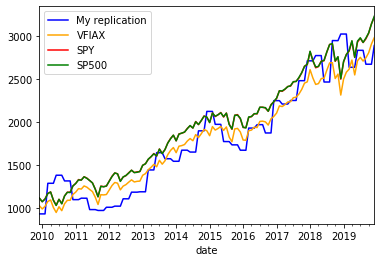

In [8]:
# Plot the prices of the replication, the index, the mutual fund, and the ETF
%pylab inline

sp_rep['SP_PRICE'].plot(label='My replication', color='blue')
VFIAX_1=VFIAX['mnav']*10
VFIAX_1.plot(label='VFIAX', color='orange')
SPY_x = SPY['PRC_ADJ']*10
SPY_x.plot(label='SPY',color='red')
SP500['spindx'].plot(label='SP500',color='green')
legend(loc='best')

SPY matches the S&P500 very well, so S&P500 (green line) covers SPY (red line) on the plot.

In [9]:
# Caculate correlation and print annualized metrics
sp_cor = pd.DataFrame({"SPY RETURN":SPY['RETURN'],"SP500 RETURN":SP500['RETURN'],\
                        "VFIAX":VFIAX['RETURN'], "SP REP RETURN":sp_rep['RETURN'] }) 
print(sp_cor.corr(),'\n')
print('Pairwise correlation')
print(stats)

               SPY RETURN  SP500 RETURN     VFIAX  SP REP RETURN
SPY RETURN       1.000000      0.997276  0.999782       0.070616
SP500 RETURN     0.997276      1.000000  0.997388       0.085587
VFIAX            0.999782      0.997388  1.000000       0.067184
SP REP RETURN    0.070616      0.085587  0.067184       1.000000 

Pairwise correlation
                     RETURN       STD    SHARPE
SP500 Replication  0.145062  0.221703  0.564099
VFIAX              0.121073  0.124477  0.811981
SP500              0.121668  0.123581  0.822690
SPY                0.120438  0.124284  0.808132


# Dow Jones Replication

In [10]:
def rebalance_dj(df2):
    df2['INDEX_PRICE'] = 0
    return df2

def reconstitute_dj(df2):
    df2 = df2.sort_values(by='PRC_ADJ', ascending=False)[0:30].reset_index(drop=True)
    df2 = rebalance_dj(df2)
    return df2

In [11]:
dow_data = pd.read_csv('1291c5ae6f37733d.csv')
dow_data['PRC_ADJ'] = (dow_data['PRC'] / dow_data['CFACPR'])
dow_data['date'] = pd.to_datetime(dow_data['date'], format='%Y%m%d').dt.to_period('M') 
dates_dj = dow_data['date'].unique()

In [12]:
col = ['date','PERMNO','TICKER', 'INDEX_PRICE']
d_j = pd.DataFrame(np.zeros((0,len(col))), columns=col)
d_jones = pd.DataFrame(np.zeros((30,len(col))), columns=col)

for i in dates_dj:
    
    # get data @ time period
    df2 = dow_data[dow_data['date']==i][['date', 'PERMNO', 'TICKER','PRC_ADJ']]
    
    # check if about to be new year for reconsititution
    if i.month%12 == 0:
        d_jones = reconstitute_dj(df2)
        constituents_dj = d_jones[['PERMNO']]

    # check if quarter for rebalancing
    elif i.month%3 == 0:
        df2 = df2.merge(constituents_dj)
        d_jones = rebalance_dj(df2)
    
    # otherwise maintain weights
    else:
        cols = ['date','PERMNO','TICKER','PRC_ADJ','INDEX_PRICE']
        df2 = df2.merge(constituents_dj,how='left')        
        d_jones = d_jones.drop(columns=['date'])
        d_jones = d_jones.merge(df2[['date','PERMNO']], how='left', left_on='PERMNO', right_on='PERMNO')[cols]

    d_j = d_j.append(d_jones).reset_index(drop=True)

In [13]:
# Calculate DJIA weighted price sum and return (replication)
divisor = .152
djia_rep = d_j.groupby(by='date')[['PRC_ADJ']].sum()
djia_rep['INDEX_PRICE'] = djia_rep['PRC_ADJ']/divisor
djia_rep['RETURN'] = (djia_rep['INDEX_PRICE'] / djia_rep['INDEX_PRICE'].shift(1) - 1)
djia_rep=djia_rep.drop(['PRC_ADJ'], axis=1)

In [14]:
# DJ ETF
DIA = pd.read_csv('dia.csv')
DIA['PRC_ADJ'] = DIA['PRC'] / DIA['CFACPR']
DIA['date'] = pd.to_datetime(DIA['date'], format='%Y%m%d').dt.to_period('M')
DIA=DIA.set_index('date')
DIA = DIA.drop(["CFACPR", "CFACSHR", "PRC", "SHROUT","COMNAM","PERMNO",'TICKER'], axis=1)
DIA['RETURN'] = (DIA['PRC_ADJ'] / DIA['PRC_ADJ'].shift(1) - 1)

# ^DJI
dji = pd.read_csv('^DJI.csv')
dji['RETURN'] = (dji['Adj Close'] / dji['Adj Close'].shift(1) - 1)
dji = dji.drop(["Open", "High", "Low", "Close","Volume"], axis=1)
dji['Date'] = pd.to_datetime(dji['Date'], format='%Y-%m-%d').dt.to_period('M')
dji=dji.set_index('Date')

# DJ MUTUAL FUND
RYDHX = pd.read_csv('mutual.csv')
RYDHX = (RYDHX[RYDHX.crsp_fundno != 31461])
RYDHX = (RYDHX[RYDHX.mret != 'R'])
RYDHX = RYDHX.drop_duplicates(subset='caldt', keep="first")
RYDHX['date'] = pd.to_datetime(RYDHX['caldt'], format='%Y%m%d').dt.to_period('M')
RYDHX=RYDHX.set_index('date')
RYDHX=RYDHX.drop(columns=['caldt','crsp_fundno','mtna','mret'])
RYDHX['RETURN'] = (RYDHX['mnav'] / RYDHX['mnav'].shift(1) - 1)

In [15]:
# annualized metrics
rf=.02

dj_rep = pd.DataFrame(djia_rep.apply(lambda x:((1+np.mean(x))**12-1)),columns=['RETURN'])
dj_rep['STD'] = djia_rep.apply(lambda x: np.std(x)*np.sqrt(12))
dj_rep['SHARPE'] = (dj_rep['RETURN']-rf)/dj_rep['STD']
dj_rep=dj_rep.drop(['INDEX_PRICE'], axis=0)
dj_rep = dj_rep.rename(index={'RETURN': 'DJIA Replication'})

m_stats = pd.DataFrame(RYDHX.apply(lambda x:((1+np.mean(x))**12-1)),columns=['RETURN'])
m_stats['STD'] = RYDHX.apply(lambda x: np.std(x)*np.sqrt(12))
m_stats['SHARPE'] = (m_stats['RETURN']-rf)/m_stats['STD']
m_stats=m_stats.drop(['mnav'], axis=0)
m_stats = m_stats.rename(index={'RETURN': 'RYDHX'})

dj_stats = pd.DataFrame(dji.apply(lambda x:((1+np.mean(x))**12-1)),columns=['RETURN'])
dj_stats['STD'] = dji.apply(lambda x: np.std(x)*np.sqrt(12))
dj_stats['SHARPE'] = (dj_stats['RETURN']-rf)/dj_stats['STD']
dj_stats=dj_stats.drop(['Adj Close'], axis=0)
dj_stats = dj_stats.rename(index={'RETURN': 'DJIA'})
 
dia_stats = pd.DataFrame(DIA.apply(lambda x:((1+np.mean(x))**12-1)),columns=['RETURN'])
dia_stats['STD'] = DIA.apply(lambda x: np.std(x)*np.sqrt(12))
dia_stats['SHARPE'] = (dia_stats['RETURN']-rf)/dia_stats['STD']
dia_stats=dia_stats.drop(['PRC_ADJ'], axis=0)
dia_stats = dia_stats.rename(index={'RETURN': 'DIA'})

dj_rep=dj_rep.append(m_stats)
dj_rep=dj_rep.append(dj_stats)
dj_rep=dj_rep.append(dia_stats)

Populating the interactive namespace from numpy and matplotlib


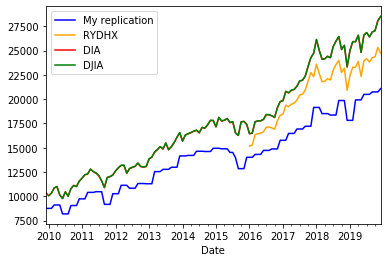

In [16]:
# Plot the prices of the replication, the index, the mutual fund, and the ETF
%pylab inline

djia_rep['INDEX_PRICE'].plot(label='My replication', color='blue')
RYDHX_1=RYDHX['mnav']*330 # multiply RYDHX by 330 to match the scale of the dow jones
RYDHX_1.plot(label='RYDHX', color='orange')
DIA_x = DIA['PRC_ADJ']*100
DIA_x.plot(label='DIA',color='red')
dji['Adj Close'].plot(label='DJIA', color='green')
legend(loc='best')

DIA matches the DJIA very well, so DJIA (green line) covers DIA (red line) on the plot. 

Also note RYDEX was only created in 2015, and it is scaled to the dow jones

In [17]:
# Caculate correlation and print annualized metrics
djia_cor = pd.DataFrame({"DIA RETURN":DIA['RETURN'],"DJIA RETURN":dji['RETURN'],\
                         "RYDHX":RYDHX['RETURN'], "DJIA REP RETURN":djia_rep['RETURN'] }) 
print(dj_rep,'\n')
print('Pairwise correlation')
print(djia_cor.corr())

                    RETURN       STD    SHARPE
DJIA Replication  0.100301  0.125935  0.637641
RYDHX             0.140652  0.117229  1.029203
DJIA              0.118726  0.119869  0.823618
DIA               0.114020  0.120531  0.780045 

Pairwise correlation
                 DIA RETURN  DJIA RETURN     RYDHX  DJIA REP RETURN
DIA RETURN         1.000000     0.999494  0.972071         0.329099
DJIA RETURN        0.999494     1.000000  0.970131         0.337788
RYDHX              0.972071     0.970131  1.000000         0.232456
DJIA REP RETURN    0.329099     0.337788  0.232456         1.000000
